In [5]:
%run _init_notebook.ipynb
from approxmh.vae import VAE, AdaptiveVAETrainer
from approxmh.distributions import IndependentMultivariateNormal, Funnel
from approxmh.samplers import AdaptiveVAESampler
from approxmh.utilities import visualize_distribution
from approxmh.likelihood_estimators import SISLikelihoodEstimator, IWLikelihoodEstimator
from approxmh.y_utils import *
from approxmh.distribution_metrics import CoordinateDistributionMetric, TotalVariation1d
from approxmh.rnvp import RNVP
from approxmh.flow_trainer import AdaptiveFlowTrainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cuda


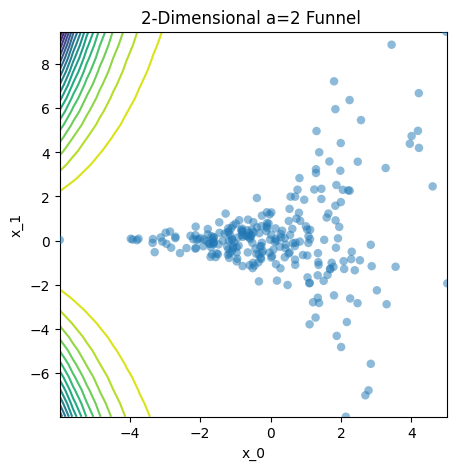

In [12]:
target = Funnel(dim=2, a=2)
visualize_distribution(target, sample_size=256, levels=20, plot_samples=True)

In [10]:
vae = VAE(
    data_dim=target.dim,
    hidden_dims=(4, 4, 4, 4, 4, 4),
    latent_dim=target.dim,
    device=device
)
vae_ml_estimator = IWLikelihoodEstimator(
    model=vae,
    L=128,
#    time_step=0.8,
#    precondition=True
)
vae_trainer = AdaptiveVAETrainer(
    target=target,
    model=vae,
    model_log_likelihood=vae_ml_estimator,
#    initial_sample=initial_sample,
    device=device,
    optimizer='adam',
    lr=1e-3,
)

flow = RNVP(num_blocks=6, dim=target.dim, device=device)
flow_trainer = AdaptiveFlowTrainer(
    flow, target, device=device,
    forward_kl_factor=1,
    backward_kl_factor=1,
    optimizer='adam',
    lr=1e-3
)

In [ ]:
def compare_learning_speed():
    batch_size = 256
    n_initial_samples = batch_size
    n_nonadaptive_batches = 400
    metric = CoordinateDistributionMetric(TotalVariation1d(), projection_coordinates=(0,1))
    models = [
        ('vae', vae, vae_trainer),
        ('flow', flow, flow_trainer)
    ]

    initial_samples = target.sample((n_initial_samples,))  # switch to NUTS samples later
    target_samples = target.sample((batch_size,))
    test_logs = defaultdict(list)
    for _, model, __ in models:
        model.train()

    for batch_idx in range(n_nonadaptive_batches):
        clear_output(wait=True)
        fig, axs = plt.subplots(ncols=2, figsize=(10,5))
        fig.suptitle(f'Batch Size {batch_size}')

compare_learning_speed()